In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet') 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Red txt data file 
with open("WhatsApp Chat with #AskPyFesh_3.txt", "r", encoding = "utf-8") as file:
    chats = file.readlines()
print(len(chats))

5073


In [3]:
#Remove new lines
chats = [line.strip() for line in chats]
chats[:10]
print(len(chats))

#Clean out the join notification lines
apfesh = [line for line in chats if not "joined using this" in line]

#Further cleaning
#Remove empty lines
apfesh = [line for line in apfesh if len(line) > 1]
print(len(apfesh))

5073
4110


In [4]:
#Remove more auto lines
apfesh = [line for line in apfesh if not "You changed" in line]
print(len(apfesh))

4104


In [5]:
#Remove even more auto lines
apfesh = [line for line in apfesh if not "You revoked" in line]
print(len(apfesh))

4101


In [6]:
#Drop 'left-ers'
left = [line for line in apfesh if line.endswith("left")]
#Remove all that 'left'
apfesh = [line for line in apfesh if not line.endswith("left")]
print(len(apfesh))
print("{} people left the group".format(len(left)))

4093
8 people left the group


In [8]:
leavers = {}
for line in left:
    leavers[line.partition('-')[2][:-5]] = line.partition('-')[0].partition(',')[0]
print(len(leavers))
leave = pd.DataFrame([leavers]).T
leave.columns = ['date']
leave

8


,date
+263 77 221 3302,10/23/19
+234 703 553 4253,11/2/19
Steph LI AskPyFesh,11/4/19
+234 706 130 1525,11/13/19
+234 703 059 4261,11/27/19
+234 903 915 7667,11/30/19
+234 810 004 6353,12/14/19
+91 99231 07798,12/29/19


In [9]:
#Drop media file lines
media = [line for line in apfesh if 'omitted' in line]
print("There were {} media files in this time".format(len(media)))
apfesh = [line for line in apfesh if not 'omitted' in line]
print(len(apfesh))

There were 136 media files in this time
3957


In [10]:
#Merge messages that belong together
msgs = [] #message container
pos = 0 #counter for position of msgs in the container
"""
Flow:
For every line, see if it matches the expression which is starting with the format "number(s)+slash" eg "12/"
If it does, it is a new line of conversion as they begin with dates, add it to msgs container
Else, it is a continuation of the previous line, add it to the previous line and append to msgs, then pop previous line.
"""
for line in apfesh:
    if re.findall("\A\d+[/]", line):
        msgs.append(line)
        pos += 1
    else:
        take = msgs[pos-1] + ". " + line
        msgs.append(take)
        msgs.pop(pos-1)

len(msgs)

2293

In [11]:
msgs[5:9]

['10/22/19, 1:30 PM - Paschal Chukwuemeka Amah: Hehe.. Na so.',
 '10/22/19, 1:30 PM - Paschal Chukwuemeka Amah: Trying to find the next big pythonista.. So, historically na Igwe enter the group first.',
 "10/22/19, 1:31 PM - Paschal Chukwuemeka Amah: I'll delete all this sha just before I start sharing links and having people join.",
 '10/22/19, 8:33 PM - Chigozie Njoku D-GASM: #AskFeshIntro. Name: Chigozie Njoku. City of residence: Lagos']

In [12]:
#Drop first two lines: auto msg
msgs = msgs[2:]
len(msgs)

2291

In [13]:
#peep message format so far
msgs[50:55]

['10/23/19, 1:03 PM - +234 706 527 3604: My name is Tolu Oladipo. I reside in Lagos state #AskFreshIntro',
 '10/23/19, 4:00 PM - Ojei Toritsemoshe D-GASM: #AskFeshIntro. Ojei Tooritse. Lagos',
 '10/23/19, 7:05 PM - Paschal Chukwuemeka Amah: _3/3 Repeat message_. Warm welcome to *#AskPyFesh*! 😁. In an hour we shall revoke the join link and open the floor.. If you have not, and would want to be enumerated, drop your first message with the tag _*#AskPyFeshIntro*_ with your preferred name and location.. *Upcoming Event*. _*Time*_: 22:15hrs GMT* (10:15pm Lagos Time). _*Agenda*_: Guidance on getting your computer ready to write the language.. _*Recommended Tools*_: Your laptop or desktop and a working Internet connection.. Again, warm welcome.. - == _This is Fesh_ 🙇. !=_Fresh_ 😀',
 '10/23/19, 7:07 PM - Obiora Michael D-GASM: Mike, Surulere Lagos #AskPyFeshIntro',
 '10/23/19, 7:08 PM - +234 805 052 8131: What if my laptop can not connect to WiFi, what do I do?']

In [14]:

#make arrays of different parts of the messages
date = []
time = []
number = []
msg = []
counter = 0
for line in msgs:
    x = line.split()
    #Get the date
    dating = x[0]
    date.append(dating.replace(',',''))
    
    #Get the time
    timing = x[1] + " " +x[2]
    time.append(timing)
    
    #Get number
    num = " ".join(x[3:9]) #the parts numbers/names fall in
    try:
        match = re.search(r"- ([^']*):", num).group(1) #match between '- ' and ':' where they are per se
        number.append(match)
    except:
        number.append("-")
        pass
    #Get message
    #num = " ".join(x[3:8]) #num/name position
    #match = re.search(r"- ([^']*):", num).group(1) #isolate the num/name per se
    part = line.partition(match)[2] #partition according to the match and extract the last part, the msg
    msging = part[2:] #strip off the first two characters as they are ": "
    msg.append(msging)
    
#     counter += 1
#     print(counter)

print(len(date), len(time), len(number), len(msg))

2291 2291 2291 2291


In [15]:
number = [line.replace('Paschal Chukwuemeka Amah', 'Fesh') for line in number]
number[:5]

['MaduDOMINIC', 'MaduDOMINIC', 'MaduDOMINIC', 'Fesh', 'Fesh']

In [16]:
#Put in a dataframe
apfesh_df = pd.DataFrame()
apfesh_df["date"] = date
apfesh_df["time"] = time
apfesh_df["number"] = number
apfesh_df["msg"] = msg

apfesh_df.head()

,date,time,number,msg
0,10/22/19,1:28 PM,MaduDOMINIC,Ask Python Fesh
1,10/22/19,1:28 PM,MaduDOMINIC,Odi ok
2,10/22/19,1:28 PM,MaduDOMINIC,Anyi ebidogo
3,10/22/19,1:30 PM,Fesh,Hehe.. Na so.
4,10/22/19,1:30 PM,Fesh,"Trying to find the next big pythonista.. So, h..."


In [37]:
apfesh_df['word_count'] = apfesh_df['msg'].apply(lambda x: len(str(x).split(" ")))
apfesh_df.head()

,date,time,number,msg,word_count
0,10/22/19,1:28 PM,MaduDOMINIC,Ask Python Fesh,3
1,10/22/19,1:28 PM,MaduDOMINIC,Odi ok,2
2,10/22/19,1:28 PM,MaduDOMINIC,Anyi ebidogo,2
3,10/22/19,1:30 PM,Fesh,Hehe.. Na so.,3
4,10/22/19,1:30 PM,Fesh,"Trying to find the next big pythonista.. So, h...",15


In [46]:
print("There are a total of {:,} words shared in this group so far".format(apfesh_df.word_count.sum()))

There are a total of 37,885 words shared in this group so far


In [34]:
members = apfesh_df.number.tolist()
members = set(members)
members = list(members)
len(members)
members

['+234 812 053 1560',
 '+234 803 399 5784',
 '+234 706 274 2832',
 '+234 806 235 5136',
 '+234 903 881 9790',
 '+234 816 833 8104',
 '+234 818 967 6168',
 '+234 812 053 1560: https',
 '+234 903 895 4127',
 '+91 99231 07798',
 '+234 805 326 3849',
 '+234 705 579 9202: https',
 '+234 808 230 9647',
 'Budo',
 'Ojonta Semi Bishop Okoye',
 '+234 803 509 7061',
 'Adafin',
 'Chigozie Njoku D-GASM: #AskFeshIntro. Name',
 'Ojei Toritsemoshe D-GASM',
 '+234 813 533 2067',
 '+234 813 533 2067: https',
 '+234 703 553 4253',
 '+234 706 753 8706',
 'Ogbosho Tupac',
 'Charles Echefu #AskPyFesh',
 'Fesh: like this',
 '+234 703 461 5552',
 '+234 803 406 5079',
 '+234 813 701 6073',
 '+234 805 411 5331',
 '+234 818 559 0066',
 'Chigozie Njoku D-GASM',
 '+234 816 440 2922',
 'Fesh: Try this',
 '+234 705 340 6810',
 '+234 818 847 1990',
 '+234 701 291 2307',
 'Fesh: Simply put',
 '+972 54-226-9638',
 '+234 816 487 2514',
 '+234 703 059 4261',
 '-',
 '+234 816 629 7839',
 '+234 803 929 4506',
 '+234 708 88

Fesh                 765
+234 803 604 4312    145
+234 806 235 5136    110
+234 812 053 1560    110
+234 705 579 9202     91
Name: number, dtype: int64


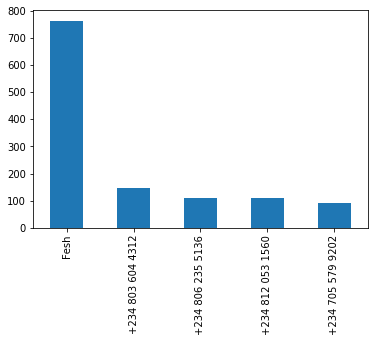

In [17]:
top5messengers = apfesh_df.number.value_counts(ascending=False).head()
print(top5messengers)
top5messengers.plot(kind="bar")

Fesh                 765
+234 803 604 4312    145
+234 806 235 5136    110
+234 812 053 1560    110
+234 705 579 9202     91
Name: number, dtype: int64


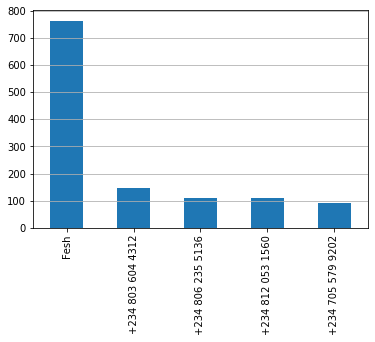

In [18]:
print(top5messengers)
fig, ax2 = plt.subplots()
top5messengers.plot(kind='bar',ax=ax2, fontsize=10, sort_columns=True)
ax2.grid(axis='y')
plt.show()

Fesh                         765
+234 803 604 4312            145
+234 806 235 5136            110
+234 812 053 1560            110
+234 705 579 9202             91
+234 701 291 2307             84
Ejike Okonkwo Acipite Bro     77
+234 813 533 2067             69
+234 903 182 7815             65
+234 816 398 2854             56
Name: number, dtype: int64


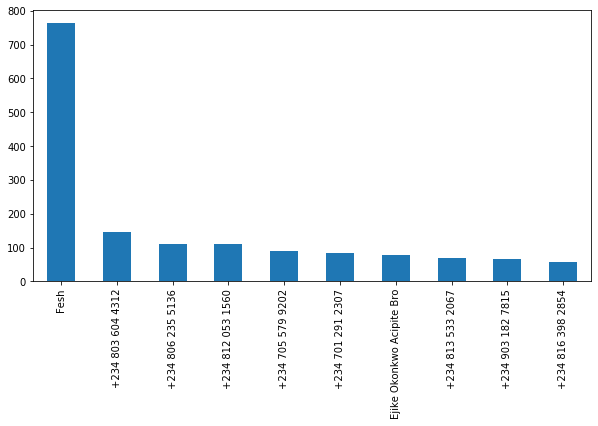

In [19]:
top10messengers = apfesh_df.number.value_counts(ascending=False).head(10)
print(top10messengers)
top10messengers.plot(kind="bar", figsize=(10,5))

Fesh                         765
+234 803 604 4312            145
+234 806 235 5136            110
+234 812 053 1560            110
+234 705 579 9202             91
+234 701 291 2307             84
Ejike Okonkwo Acipite Bro     77
+234 813 533 2067             69
+234 903 182 7815             65
+234 816 398 2854             56
Name: number, dtype: int64


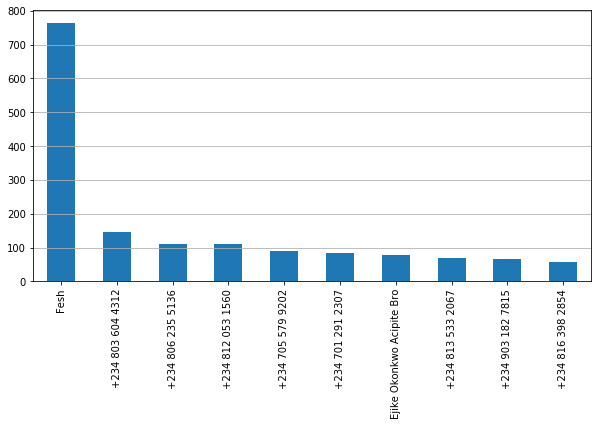

In [20]:
print(top10messengers)
fig, ax2 = plt.subplots()
top10messengers.plot(kind='bar',ax=ax2, fontsize=10, sort_columns=True, figsize=(10,5))
ax2.grid(axis='y')
plt.show()

In [21]:
len(apfesh)

3957

In [24]:
pd.Series(' '.join(apfesh_df['msg']).split()).value_counts().tail(20)
pd.Series(' '.join(apfesh_df['msg']).split()).value_counts().head(20)

the     1481
to      1052
a        841
and      700
you      682
I        647
is       635
of       549
it       486
in       431
for      424
will     303
are      287
have     271
be       266
on       259
this     258
that     255
can      223
with     212
dtype: int64

In [25]:
##Create a list of stopwords
stop_words = set(stopwords.words("english"))
new_words = set(apfesh_df['number'].tolist())
new_words = [line.lower() for line in new_words]
more = ['media omitted']
stop_words = stop_words.union(new_words)
stop_words = stop_words.union(more)
len(new_words)

116

In [26]:
##Preprocessing
def cleaner1(words):
    corpus = []
    for i in range(0, len(words)):
        #Remove punctuations. Removes all characters NOT a-z or A-Z and replace with nothing ie ' ' note: carat inside the []
        text = re.sub('[^a-zA-Z]', ' ', words[i])

        #Convert to lowercase
        text = text.lower()

        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)

        ##Convert to list from string
        text = text.split()

        ##Stemming
        ps=PorterStemmer()
        #Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        if "rt" in text:
            corpus.append(text.split(' ',2)[2:])
        else:
            corpus.append(text)
    return corpus

cleaned_words = cleaner1(apfesh_df['msg'].tolist())

In [27]:
len(apfesh_df.msg)

2291

#AskPyFesh Wordcloud


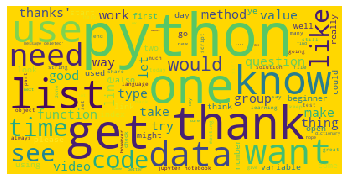

In [29]:
#Word cloud
print("#AskPyFesh Wordcloud")
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='gold',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=70, 
                          random_state=42
                         ).generate(str(cleaned_words))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)